From Yee+ (2020 - https://iopscience.iop.org/article/10.3847/2041-8213/ab5c16):
$$
t_{\rm tra} = T_0 + E P_{\rm s} - \frac{e P_{\rm a}}{\pi} \cos \omega(E),
$$

$$
t_{\rm occ} = T_0 + \frac{P_{\rm a}}{2} + E P_{\rm s} + \frac{e P_{\rm a}}{\pi} \cos \omega(E),
$$

$$
\omega(E) = \omega_0 + \left( \frac{d\omega}{dE} \right) E,\ {\rm and}
$$

$$
P_{\rm s} = P_{\rm a} \left( 1 - \frac{1}{2\pi} \frac{d\omega}{dE} \right).
$$

Each *observed* (as opposed to *predicted*) mid-time, $t_{i{\rm, tra}}$ and $t_{i{\rm, occ}}$, will have an uncertainty $\sigma_{i{\rm, tra}}$ and $\sigma_{i{\rm, occ}}$, respectively. 

The parameters whose uncertainties we want to estimate are $T_0$, $P_{\rm s}$, $e$, $\omega_0$, and $d\omega/dE$.

Let's include a plot of precessing $t_{\rm tra}$ and $t_{\rm occ}$ so we can see what they look like:

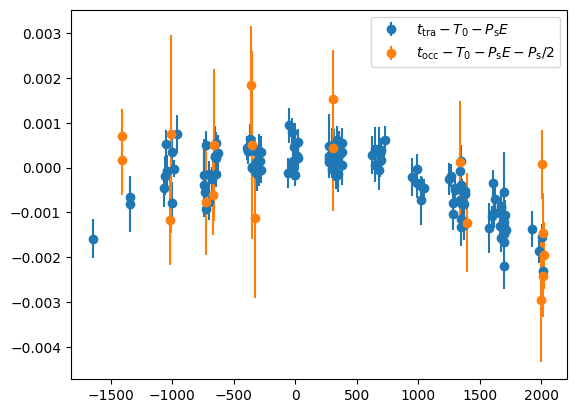

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calc_omega(E, omega_0, domega_dE):
    return omega_0 + domega_dE*E

def calc_Pa(Ps, domega_dE):
    return Ps/(1. - 1./2/np.pi*domega_dE)

def calc_ttra(E, T0, Ps, e, omega_0, domega_dE):
    omega = calc_omega(E, omega_0, domega_dE)
    Pa = calc_Pa(Ps, domega_dE)

    return T0 + E*Ps - e*Pa/np.pi*np.cos(omega)

def calc_tocc(E, T0, Ps, e, omega_0, domega_dE):
    omega = calc_omega(E, omega_0, domega_dE)
    Pa = calc_Pa(Ps, domega_dE)

    return T0 + Pa/2. + E*Ps + e*Pa/np.pi*np.cos(omega)

# This is the REAL DATA for WASP-12 b pulled from Yee et al.
url = "https://raw.githubusercontent.com/BoiseStatePlanetary/susie/refs/heads/main/example_data/wasp12b_tra_occ.csv"
data = pd.read_csv(url)
tra_or_occs = np.array(data["tra_or_occ"])
epochs = np.array(data["epoch"].astype('int'))
mid_times = np.array(data["mid_time"])
mid_time_errs = np.array(data["mid_time_err"])

# Taken from Yee+ (2020)
T0 = 2456305.455521
Ps = 1.091420107
e = 0.05 # made up
omega_0 = 2.62 # radians
domega_dE = 0.000984 # rad per orbit

E = epochs
E_tra = E[tra_or_occs == "tra"]
E_occ = E[tra_or_occs == "occ"]
ttra = mid_times[tra_or_occs == "tra"]
tocc = mid_times[tra_or_occs == "occ"]
sigma_tra = mid_time_errs[tra_or_occs == "tra"]
sigma_occ = mid_time_errs[tra_or_occs == "occ"]

plt.errorbar(E_tra, ttra - T0 - Ps*E_tra, yerr=sigma_tra, marker='o', ls='', label=r'$t_{\rm tra} - T_0 - P_{\rm s} E$')
plt.errorbar(E_occ, tocc - T0 - Ps*E_occ - Ps/2., yerr=sigma_occ, marker='o', ls='', label=r'$t_{\rm occ} - T_0 - P_{\rm s} E - P_{\rm s}/2$')
plt.legend(loc='best')

plt.show()

We need to find the best-fit values for these parameters by minimizing $\chi^2$:
$$
\chi^2 = \sum_{i = 0}^{N-1} \left( \frac{t_i - t(E_i)}{\sigma_i} \right)^2 = \sum_{i = 0}^{E-1} \left( \frac{t_i - T_0 - P_{\rm s} E_i - \left( \frac{e P_{\rm a}}{\pi} \right) \cos \omega(E_i)}{\sigma_i} \right)^2.
$$

Let's try expanding the last term in $\chi^2$ about small quantities:
$$
\left( \frac{e P_{\rm a}}{\pi} \right) \cos \omega(E_i) = \left( \frac{e P_{\rm s}}{\pi\left( 1 - \frac{1}{2\pi} \frac{d\omega}{dE}\right)} \right) \cos \left( \omega_0 + \frac{d\omega}{dE}E_i \right) = \left( \frac{e P_{\rm s}}{\pi\left( 1 - \frac{1}{2\pi} \frac{d\omega}{dE}\right)} \right)  \left( \cos \left( \omega_0 \right) \cos \left( \frac{d\omega}{dE}E_i \right) - \sin \left( \omega_0 \right) \sin \left( \frac{d\omega}{dE}E_i \right)\right) 
$$

$$
\approx \left( \frac{e P_{\rm s}}{\pi} \right) \left( 1 + \frac{1}{2\pi} \frac{d\omega}{dE}\right) \left( \cos \left( \omega_0 \right) - \sin \left( \omega_0 \right) \left( \frac{d\omega}{dE}E_i \right) \right) \approx \left( \frac{e P_{\rm s}}{\pi} \right) \cos \omega_0.
$$

So at the first order in small quantities $d\omega/dE$ doesn't appear.

$$
\chi^2 \approx \sum_{i = 0}^{N - 1}\sigma_i^{-2} \left( t_i - T_0 - P_{\rm s} \left( E_i - \frac{e \cos \omega_0}{\pi} \right) \right)^2
$$

$$
\frac{\partial \chi^2}{\partial T_0} = 0 \Rightarrow 0 \approx \sum_{i = 0}^{N - 1}\sigma_i^{-2} \left( t_i - T_0 - P_{\rm s} \left( E_i - \frac{e \cos \omega_0}{\pi} \right) \right) = S_t - T_0 S - P_{\rm s} \left( S_E - S \frac{e \cos \omega_0}{\pi} \right)
$$

$$
\frac{\partial \chi^2}{\partial P_{\rm s}} = 0 \Rightarrow 0 \approx \sum_{i=0}^{N-1} \sigma_i^{-2} \left( t_i - T_0 - P_{\rm s} \left( E_i - \frac{e \cos \omega_0}{\pi} \right) \right) \left( E_i - \frac{e \cos \omega_0}{\pi} \right)
$$

$$
= S_{Et} - T_0 S_E - P_{\rm s}\left( S_{E^2} - S_E \frac{e \cos \omega_0}{\pi}\right) - \left( S_t - T_0 S - P_{\rm s} \left( S_E -S \frac{e \cos \omega_0}{\pi} \right) \right) \frac{e \cos \omega_0}{\pi} 
$$

We can write the uncertainty for each parameter $f$ as it depends on each observational data point $y_{i}$ as
$$
\sigma_{f}^2 \approx \sum_{i = 0}^{E-1} \sigma_{i}^2 \left( \frac{\partial f}{\partial y_{i}} \right)^2.
$$

Since the derivatives should be well-behaved, we can calculate the derivatives of the transit and occultation midtimes with respect to each parameter and then flip them over to calculate the derivatives of the parameter with respect to the midtimes.
$$
\left( \frac{\partial t_{i{\rm, tra/occ}}}{\partial T_0} \right) = 1,
$$

$$
\left( \frac{\partial t_{i{\rm, tra}}}{\partial P_{\rm s}} \right) = E - \frac{e}{\pi \left( 1 - \frac{1}{2\pi} \frac{d\omega}{dE}\right)} \cos \omega (E),
$$

$$
\left( \frac{\partial t_{i{\rm, occ}}}{\partial P_{\rm s}} \right) = \left( E + \frac{1}{2 \left( 1 - \frac{1}{2\pi} \frac{d\omega}{dE}\right)} \right) + \frac{e}{\pi \left( 1 - \frac{1}{2\pi} \frac{d\omega}{dE}\right)} \cos \omega (E),
$$

$$
\left( \frac{\partial t_{i,{\rm tra/occ}}}{\partial e} \right) = \mp\frac{P_{\rm s}}{\pi\left(1 - \frac{1}{2\pi}\frac{d\omega}{dE}\right)} \cos \omega \left(E\right),
$$

$$
\left( \frac{\partial t_{i,{\rm tra/occ}}}{\partial \omega_0} \right) = \pm\frac{eP_{\rm s}}{\left( 1 - \frac{1}{2\pi}\frac{d\omega}{dE}\right)\pi} \sin \omega \left( E \right),
$$

$$
\left( \frac{\partial t_{i,{\rm tra}}}{\partial \left( \frac{d\omega}{dE} \right)} \right) = \frac{e P_{\rm s}}{\pi \left( 1 - \frac{1}{2\pi}\frac{d\omega}{dE}\right)} \left( E \sin \omega \left( E\right) - \frac{\cos \omega \left( E\right) }{2\pi \left( 1 - \frac{1}{2\pi}\frac{d\omega}{dE}\right)} \right),\ {\rm and}
$$

$$
\left( \frac{\partial t_{i,{\rm occ}}}{\partial \left( \frac{d\omega}{dE} \right)} \right)= \frac{P_{\rm s}}{4\pi\left( 1 - \frac{1}{2\pi} \frac{d\omega}{dE} \right)^2} + \frac{e P_{\rm s}}{\pi \left( 1 - \frac{1}{2\pi}\frac{d\omega}{dE}\right)} \left( -E \sin \omega \left( E\right) + \frac{\cos \omega \left( E\right) }{2\pi \left( 1 - \frac{1}{2\pi}\frac{d\omega}{dE}\right)} \right).
$$

We can simplify some of these expressions because $e \ll 1$, $d\omega/dE \ll 1$, $E \ge 0$, and $|\cos \left( \right)|$ \& $|\sin \left( \right)| \le 1$. We're going to do a sum over all the transits and occultations, so even when we have an $E = 0$ term in the sum, we will have terms with larger $E$. Also, we're going to square all the terms. Thus, 
$$
\left( \frac{\partial t_{i{\rm, tra/occ}}}{\partial T_0} \right) = 1,
$$

$$
\left( \frac{\partial t_{i{\rm, tra}}}{\partial P_{\rm s}} \right) \approx E,
$$

$$
\left( \frac{\partial t_{i{\rm, occ}}}{\partial P_{\rm s}} \right) \approx \left( E + \frac{1}{2} \right),
$$

$$
\bigg|\frac{\partial t_{i,{\rm tra/occ}}}{\partial e}\bigg| \approx \frac{P_{\rm s}\cos \omega\left( E \right)}{\pi},
$$

$$
\bigg| \frac{\partial t_{i,{\rm tra/occ}}}{\partial \omega_0} \bigg| \approx \frac{eP_{\rm s}\sin \omega \left( E \right) }{\pi},\ {\rm and}
$$

$$
\bigg| \frac{\partial t_{i,{\rm tra}}}{\partial \left( \frac{d\omega}{dE} \right)} \bigg| \approx \frac{e P_{\rm s} E \sin \omega \left( E \right) }{\pi}.
$$

We can simplify the expression for $\frac{\partial t_{i,{\rm occ}}}{\partial \left( \frac{d\omega}{dE} \right)}$ by approximating $P_{\rm a} \approx P_{\rm s}$, which amounts to ignoring the first term in the $\frac{\partial t_{i,{\rm occ}}}{\partial \left( \frac{d\omega}{dE} \right)}$ equation above. This approach gives

$$
\bigg| \frac{\partial t_{i,{\rm occ}}}{\partial \left( \frac{d\omega}{dE} \right)} \bigg| \approx \frac{e P_{\rm s} E \sin \omega \left( E \right) }{\pi}.
$$

$T_0$, $P_{\rm s}$, $e$, $\omega_0$, and $d\omega/dE$.

And now let's turn these expressions into estimates for uncertainties:
$$
\sigma_{T_0} = \sqrt{\sum_i \sigma_{i,{\rm tra/occ}}^2}
$$

$$
\sigma_{P_{\rm s}} = \sqrt{\sum_{i \in {\rm tra}} \left( \frac{\sigma_{i,{\rm tra}}}{E_i} \right)^2 + \sum_{i \in {\rm occ}} \left( \frac{\sigma_{i,{\rm tra}}}{E_i + \frac{1}{2}} \right)^2}
$$

$$
\sigma_{e} = \left( \frac{\pi}{P_{\rm s}} \right)\sqrt{\sum_i \left( \frac{\sigma_{i,{\rm tra/occ}} }{\cos \omega\left( E_i \right)} \right)^2 }
$$

$$
\sigma_{\omega_0} = \left( \frac{\pi}{e P_{\rm s}} \right)\sqrt{\sum_i \left( \frac{\sigma_{i,{\rm tra/occ}} }{\sin \omega\left( E_i \right)} \right)^2 }
$$

$$
\sigma_{d\omega/dE} = \left( \frac{\pi}{e P_{\rm s}} \right)\sqrt{\sum_i \left( \frac{\sigma_{i,{\rm tra/occ}} }{E\sin \omega\left( E_i \right)} \right)^2 }
$$

So let's try an example, again using Yee+ (2020) as our basis.

In [3]:
def calc_anal_sigma_T0(E, sigma, T0, Ps, e, omega_0, domega_dE):
    return np.sqrt(np.sum(sigma**2))    

def calc_anal_sigma_Ps(E, sigma, T0, Ps, e, omega_0, domega_dE):
    # Only good for transit data; need to expand to occultations!
    return np.sqrt(np.sum(sigma**2/E**2))

def calc_anal_sigma_e(E, sigma, T0, Ps, e, omega_0, domega_dE):
    omega = calc_omega(E, omega_0, domega_dE)
    
    return (np.pi/Ps)*np.sqrt(np.sum(sigma**2/np.cos(omega)**2))

def calc_anal_sigma_omega_0(E, sigma, T0, Ps, e, omega_0, domega_dE):
    omega = calc_omega(E, omega_0, domega_dE)

    return (np.pi/e/Ps)*np.sqrt(np.sum(sigma**2/np.sin(omega)**2))

def calc_anal_sigma_omega_domega_dE(E, sigma, T0, Ps, e, omega_0, domega_dE):
    omega = calc_omega(E, omega_0, domega_dE)

    return (np.pi/e/Ps)*np.sqrt(np.sum(sigma**2/E**2/np.sin(omega)**2))

Best-Fit T0, Ps, e, omega_0, domega_dN:  [2.45630546e+06 1.09142030e+00 9.13643945e-03 2.68551380e+00
 1.00243944e-03]
Unc on T0, Ps, e, omega_0, domega_dN:  [1.03608308e-05 1.05520684e-08 9.79975227e-06 2.14358841e-03
 1.13232827e-06]
sum:  0.00010000444063392586
anal_sigma_T0, anal_sigma_Ps:  0.0001 0.00010000444063392586


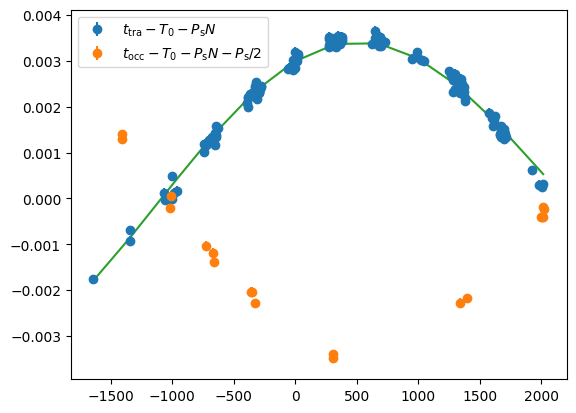

In [17]:
from numpy.random import normal
from scipy.optimize import curve_fit

# Taken from Yee+ (2020)
T0 = 2456305.455521
Ps = 1.091420107
e = 0.01 # made up
omega_0 = 2.62 # radians
domega_dE = 0.000984 # rad per orbit

# Generate synthetic data
ttra_noise = 0.0001 # days
tocc_noise = 0.0001 # days

noisy_ttra = calc_ttra(E_tra, T0, Ps, e, omega_0, domega_dE) + normal(scale=ttra_noise, size=len(E_tra))
noisy_tocc = calc_tocc(E_occ, T0, Ps, e, omega_0, domega_dE) + normal(scale=tocc_noise, size=len(E_occ))

plt.errorbar(E_tra, noisy_ttra - T0 - Ps*E_tra, yerr=ttra_noise, marker='o', ls='', label=r'$t_{\rm tra} - T_0 - P_{\rm s} E$')
plt.errorbar(E_occ, noisy_tocc - T0 - Ps*E_occ - Ps/2., yerr=tocc_noise, marker='o', ls='', label=r'$t_{\rm occ} - T_0 - P_{\rm s} E - P_{\rm s}/2$')
plt.legend(loc='best')

# calc_tocc(E, T0, Ps, e, omega_0, domega_dE)
popt, pcov = curve_fit(calc_ttra, E_tra, noisy_ttra, sigma=ttra_noise, p0=[2e6, 1., 0.01, 2.7, 1e-3], absolute_sigma=True)
plt.plot(E_tra, calc_ttra(E_tra, *popt) - T0 - Ps*E_tra)
unc = np.sqrt(np.diag(pcov))
print("Best-Fit T0, Ps, e, omega_0, domega_dE: ", popt)
print("Unc on T0, Ps, e, omega_0, domega_dE: ", unc)

# Eeed to shift E_tra
anal_sigma_T0 = calc_anal_sigma_T0(E_tra - np.min(E_tra) + 1., ttra_noise, T0, Ps, e, omega_0, domega_dE)
anal_sigma_Ps = calc_anal_sigma_Ps(E_tra - np.min(E_tra) + 1., ttra_noise, T0, Ps, e, omega_0, domega_dE)
print("sum: ", np.sqrt(np.sum(ttra_noise**2/(E_tra - np.min(E_tra) + 1.)**2)))
print("anal_sigma_T0, anal_sigma_Ps: ", anal_sigma_T0, anal_sigma_Ps)
# print("Correct T0, Ps, e, omega_0, domega_dE: ", T0, Ps, e, omega_0, domega_dE)

plt.show()